In [1]:
from queue import Queue
import numpy as np
import math
from operator import itemgetter
from cacheout import Cache

edge_count = 0

class SystolicArrayCell:
    def __init__(self, row_n, col_n):
        self.pos_x = 0
        self.pos_y = 0
        self.row_n = row_n
        self.col_n = col_n
        
        #ring register
        self.receive_cell = None  #接收数据寄存器
        self.receive_reg = 1
        self.receive_out = 0
        #self.send    =   #发送数据寄存器
        
        #On chip buffer
        self.result_bank_input = None
        
        #edge update
        self.process_id = 0
        self.process_id_out = 0
        self.next_src = -1
        self.next_dst = -1
        self.src = -1
        self.dst = -1
        self.rb_depth = 0
        self.rb_value = 0
        self.edge_empty   = False
        self.edge_compute = True
        self.hold         = False
        self.edge_number = 0
        
        self.cache_bank = None

    # Connects this cell to its neighbors above and to the left
    def connect(self, pos_x, pos_y, array):
        self.pos_x = pos_x
        self.pos_y = pos_y
        self.edge_number = pos_y
        #ring dataflow
        #if self.pos_y is array.row_n-1:
        #    self.receive_cell = array.cells[0][self.pos_x] #cell 第一个代表行数，也就是Y， 第二个代表列数，也就是X
        # Otherwise, it's another cell
        #else:
        #    self.receive_cell = array.cells[self.pos_y+1][self.pos_x]
        #each PE on the same row connect to the same result bank
        self.cache_bank        = array.cache_bank[self.pos_y]
        self.result_bank_input = array.result_bank[self.pos_y][self.pos_x]
        self.edge_bank         = array.edge_bank[self.pos_y]

    def set_process_id(self, idx):
        for id_ in idx:
            self.cache_bank.set(id_, 'none')
        
    # We'll model the transfer of signals through registers with a read() and a
    # compute() method. 
    # read() represents the registers sampling data at the positive edge of the
    # clock
    def read(self, edge_update):
        #ring dataflow 
        #print("Enter | cell({:d},{:d}) next_src {:d}, next_dst {:d}, src {:d}, dst {:d}, process_id {:d}". format(self.pos_x, self.pos_y, self.next_src, self.next_dst, self.src, self.dst, self.process_id))
        if self.edge_bank.empty():
            self.edge_empty = True
        elif self.edge_compute or edge_update:
            self.src, self.dst = self.edge_bank.get()
            self.hold         = True
            self.edge_compute = False
        else:
            self.edge_compute = False
        
        #if edge_update:
        #    self.process_id = self.process_id
        #else:
        #    self.receive_reg = self.receive_cell.receive_out
        #   self.process_id  = self.receive_cell.process_id_out
        
        #print("Medium | cell({:d},{:d}) next_src {:d}, next_dst {:d}, src {:d}, dst {:d}, process_id {:d}". format(self.pos_x, self.pos_y, self.next_src, self.next_dst, self.src, self.dst, self.process_id))
        if self.cache_bank.has(self.src) and self.hold:
            self.edge_compute = True
            self.hold         = False
        else:
            self.edge_compute = False
        
        self.rb_depth = int(self.dst/self.row_n)
        #print("Out | cell({:d},{:d}) next_src {:d}, next_dst {:d}, src {:d}, dst {:d}, process_id {:d}". format(self.pos_x, self.pos_y, self.next_src, self.next_dst, self.src, self.dst, self.process_id))
        self.rb_value = self.result_bank_input[self.rb_depth]
        

    # compute() represents combinational logic that takes place between 
    # positive edges of the clock (multiplication and addition)
    def compute(self):
        #ring dataflow
        if self.edge_compute:
            print("compute cell({:d},{:d}) src {:d}, dst {:d}". format(self.pos_x, self.pos_y, self.src, self.dst))
            global edge_count
            edge_count = edge_count + 1
            self.result_bank_input[self.rb_depth] = self.rb_value + self.receive_reg
        self.receive_out = self.receive_reg
        self.process_id_out = self.process_id
        #print("cell({:d},{:d}), hold {:d}, edge_empty {:d}". format(self.pos_x, self.pos_y, self.hold, self.edge_empty))
        #print(self.edge_number)
        
        
    def cell_state(self):
        #print("cell({:d},{:d}),rec_reg={:d}, rec_out={:d}, proc_id={:d}, proc_out={:d}". format(self.pos_x, self.pos_y, self.receive_reg, self.receive_out, self.process_id, self.process_id_out))
        print("cell({:d},{:d}),rec_reg={:d}, proc_id={:d}, rb_value={:d}". format(self.pos_x, self.pos_y, self.receive_reg, self.process_id, self.rb_value))

In [2]:
# This represents our entire array: cells, inputs, and outputs
class SystolicArray:
    # We'll take a parameter for the size of the square arrays to be multiplied
    def __init__(self, row_n, col_n):
        self.row_n = row_n
        self.col_n = col_n

        # "cells" will hold the array of processing elements
        self.cells = []
        # This array is a square with dimensions "array_size"
        for _ in range(self.row_n):
            row = []
            for _ in range(self.col_n):
                cell = SystolicArrayCell(row_n, col_n)
                row.append(cell)
            self.cells.append(row)
        
        self.cache_bank  = [Cache(maxsize=self.row_n) for _ in range(self.row_n)]
        self.edge_bank   = [Queue() for _ in range(self.row_n)]
        self.result_bank = [[list() for _ in range(self.col_n)] for _ in range(self.row_n)]

        # When all cells and inputs are created, then they can be connected 
        # (again, this would be accomplished with wiring)
        for row_num, row in enumerate(self.cells):
            for col_num, cell in enumerate(row):
                cell.connect(col_num, row_num, self) #每一行对应一个pos_y, 每一列对应一个pos_x
    
    #ring dataflow
    def edge_dual_ring_boardcase(self, row_n, src, dst):
        Edge_list  = [list() for _ in range(row_n)]
        for idx in sorted(zip(src, dst), key=itemgetter(1)):
            src, dst = idx
            Edge_list[dst%row_n].append(idx)
        for idx_, val in enumerate(Edge_list):
            for val_ in sorted(val):
                self.edge_bank[idx_].put(val_)
    
    def edge_bucket_empty(self, e_b):
        for idx in e_b:
            for id_ in idx:
                if id_.empty() is False:
                    return True
        return False

    def edge_load_balance(self, row_n, src, dst):
        Edge_bucket   = [[Queue() for _ in range(row_n)] for _ in range(row_n)]
        for idx in sorted(zip(src, dst)):
            src, dst = idx
            Edge_bucket[src%row_n][dst%row_n].put(idx)
        while(self.edge_bucket_empty(Edge_bucket)):
            for i in range(row_n):
                num = [j for j in range(i,row_n)]
                for n in range(i):
                    num.append(n)
                for id_, val in enumerate(num):
                    #print("--({:d}, {:d})". format(val, id_))
                    if Edge_bucket[val][id_].empty() is False:
                        self.edge_bank[id_].put(Edge_bucket[val][id_].get())
    
    def edge_preprocess(self, num_node, edge_src, edge_dst):
        src, dst = zip(*(sorted(zip(edge_src, edge_dst), key=itemgetter(1))))
        result = [list() for _ in range(num_node)]
        for idx in range(len(dst)):
            result[dst[idx]].append((src[idx],dst[idx]))
        for idx in range(len(result)):
            #print(idx)
            #print(len(result[idx]))
            if len(result[idx]) is 0:
                result[idx] = []
            else:
                src, dst = zip(*result[idx])
                result_A = []
                result_B = []
                for idx_ in range(len(src)):
                    if(src[idx_] >= (dst[idx_]%self.row_n)):
                        result_A.append((src[idx_], dst[idx_]))
                    else:
                        result_B.append((src[idx_], dst[idx_]))
                result_A.extend(result_B)
                result[idx] = result_A
        return result

    def fill_edges(self, num_node, edge_src, edge_dst):
        edge_ = self.edge_preprocess(num_node, edge_src, edge_dst)
        for i, val in enumerate(edge_):
            for e in val:
                self.edge_bank[i%self.row_n].put(e)
                
    def fill_result_banks(self, num_nodes):
        for row_num in range(self.row_n):
            for idx_ in range(self.col_n):  
                for _ in range(math.ceil(num_nodes/self.row_n)):
                    self.result_bank[row_num][idx_].append(0)
                    
    def fill_idx(self,idx):
        for row_num in range(self.row_n):
            for col_num in range(self.col_n):
                self.cells[row_num][col_num].set_process_id(idx)
    
    # For this demo, all cells will read() the values of their neighbors first
    def read(self,edge_update):
        for row in self.cells:
            for cell in row:
                cell.read(edge_update)

    # And then after all cells have read(), they will compute() the next step
    def compute(self):
        for row in self.cells:
            for cell in row:
                cell.compute()
                
    def terminal_signal(self):
        for row in self.cells:
            for cell in row:
                #print(cell.hold)
                #print(cell.edge_bank.empty())
                if cell.hold or not cell.edge_empty:
                    return False
        return True
        #for id_x in self.edge_bank:
        #    if id_x.empty() is False:
        #        return False
        #return True
            
            
    def show_staus(self):
        for row in self.cells:
            for cell in row:
                cell.cell_state()
                
    # Each cycle involves a read() and a compute()
    def cycle(self, edge_update):
        # read() models register sampling on the positive edge of the clock
        self.read(edge_update)
        # compute() models the combinational logic between clock edges
        self.compute()
        #self.show_staus()

    # run() will execute the array's computation, assuming it's been filled
    def run(self, num_nodes):
        # It takes 3n-2 cycles to compute the full matrix of results
        edge_update = True
        cycle = 0
        while 1:
            print("-----Cycle----{:d}----------". format(cycle))
            self.cycle(edge_update)
            edge_update = False
            #self.get_edge_output(num_nodes)
            if(self.terminal_signal()):
                break
            cycle = cycle + 1
        return cycle
        #return self.get_outputs()

    # The outputs are also staggered and transposed, so we'll format them 
    # before returning the results
    def get_outputs(self):
        ret = []

        return ret

    def get_edge_output(self, num_nodes):
        for id_x in range(num_nodes):
            print("id={:d}-|-{:d}". format(id_x, self.result_bank[int(id_x%self.row_n)][0][int(id_x/self.row_n)]))

In [5]:
# Here we'll use a small 3x3 test multiplication to see the systolic array
# in action
row_n = 3
col_n = 1
myArray = SystolicArray(row_n, col_n)

#src = [0,1,2,1,2,0,2,0,1]
#dst = [0,1,2,0,1,2,0,1,2]

#src = [0,0,0,0,1,1,2,2,2]
#dst = [0,1,3,5,2,4,0,3,5]

src = [0,1,1,2,0,0,0,2,2]
dst = [0,2,4,0,1,3,5,3,5]

#src = [0,1,1,2,0,1,0,2,2]
#dst = [0,2,4,0,1,3,5,4,5]

#src = [0,0,1,2]
#dst = [0,1,2,0]

#myArray.fill_edges(6, src, dst)
#myArray.edge_load_balance(row_n, src, dst)
myArray.edge_dual_ring_boardcase(row_n, src, dst)
idx = [0,1,2]
myArray.fill_idx(idx)
myArray.fill_result_banks(6)       

res = myArray.run(6)
#assert (res == np.matmul(activations, weights)).all()
#print('Systolic array matches numpy matmul')

-----Cycle----0----------
compute cell(0,0) src 0, dst 0
compute cell(0,1) src 0, dst 1
compute cell(0,2) src 0, dst 5
-----Cycle----1----------
compute cell(0,0) src 0, dst 3
compute cell(0,1) src 1, dst 4
compute cell(0,2) src 1, dst 2
-----Cycle----2----------
compute cell(0,0) src 2, dst 0
compute cell(0,2) src 2, dst 5
-----Cycle----3----------
compute cell(0,0) src 2, dst 3
-----Cycle----4----------


In [1]:
import argparse, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from dgl import graph_index
from dgl.graph_index import disjoint_partition
from dgl.data import register_data_args, load_data
import math

In [2]:
    parser = argparse.ArgumentParser(description='GCN')
    parser.add_argument("--dataset", type=str, default="cora",
            help="dropout probability")
    parser.add_argument("--dropout", type=float, default=0.5,
            help="dropout probability")
    parser.add_argument("--gpu", type=int, default=-1,
            help="gpu")
    parser.add_argument("--lr", type=float, default=1e-2,
            help="learning rate")
    parser.add_argument("--n-epochs", type=int, default=200,
            help="number of training epochs")
    parser.add_argument("--n-hidden", type=int, default=16,
            help="number of hidden gcn units")
    parser.add_argument("--n-layers", type=int, default=1,
            help="number of hidden gcn layers")
    parser.add_argument("--weight-decay", type=float, default=5e-4,
            help="Weight for L2 loss")
    parser.add_argument("--self-loop", action='store_true',
            help="graph self-loop (default=False)")
    parser.set_defaults(self_loop=False)
    args = parser.parse_args(args=[])

In [3]:
    data = load_data(args)
    features = torch.FloatTensor(data.features)
    labels = torch.LongTensor(data.labels)
    train_mask = torch.ByteTensor(data.train_mask)
    val_mask = torch.ByteTensor(data.val_mask)
    test_mask = torch.ByteTensor(data.test_mask)
    in_feats = features.shape[1]
    n_classes = data.num_labels
    n_edges = data.graph.number_of_edges()

In [4]:
g = DGLGraph(data.graph)

In [5]:
g.number_of_nodes()

2708

In [11]:
partition_size = 64
Node_index = []
Edge = []
Edge_number = []
partition_number = math.ceil(g.number_of_nodes() / partition_size)
print("the graph split to {:d} part". format(partition_number))
for node_id in range(partition_number):
    #print(node_id)
    if node_id == partition_number-1:
        index = list(range(partition_size*node_id,g.number_of_nodes()))
    else:
        index = list(range(partition_size*node_id,partition_size*(node_id+1)))
    Node_index.append(index)
    src, dst = g.out_edges(index)
    Edge.append(list(zip(src.tolist(),dst.tolist())))
    Edge_number.append(src.shape[0])

the graph split to 43 part


In [12]:
src, dst = zip(*Edge[0])

In [13]:
idx = Node_index[0]

In [17]:
edge_count = 0
row_n = 64
col_n = 1
cycle_list = []
for i, val in enumerate(Edge):
    src, dst = zip(*val)
    idx = Node_index[i]
    for i in range(len(idx),row_n):
        idx.append(0)
    myArray = SystolicArray(row_n, col_n)
    #myArray.fill_edges(2708, src, dst)
    myArray.edge_load_balance(row_n, src, dst)
    myArray.fill_idx(idx)
    myArray.fill_result_banks(2708)       
    res = myArray.run(2708)
    cycle_list.append(res)

-----Cycle----0----------
compute cell(0,0) src 8, dst 0
compute cell(0,1) src 10, dst 193
compute cell(0,2) src 7, dst 258
compute cell(0,3) src 49, dst 643
compute cell(0,4) src 14, dst 708
compute cell(0,5) src 9, dst 453
compute cell(0,6) src 28, dst 1606
compute cell(0,7) src 10, dst 519
compute cell(0,8) src 14, dst 8
compute cell(0,9) src 14, dst 393
compute cell(0,10) src 19, dst 74
compute cell(0,11) src 20, dst 267
compute cell(0,12) src 14, dst 268
compute cell(0,13) src 24, dst 269
compute cell(0,14) src 20, dst 334
compute cell(0,15) src 15, dst 399
compute cell(0,16) src 14, dst 400
compute cell(0,17) src 22, dst 2257
compute cell(0,18) src 39, dst 82
compute cell(0,19) src 11, dst 659
compute cell(0,20) src 25, dst 20
compute cell(0,21) src 41, dst 533
compute cell(0,22) src 36, dst 2390
compute cell(0,23) src 41, dst 23
compute cell(0,24) src 36, dst 2072
compute cell(0,25) src 38, dst 1689
compute cell(0,26) src 2, dst 410
compute cell(0,27) src 38, dst 219
compute cel

compute cell(0,9) src 161, dst 713
compute cell(0,10) src 163, dst 714
compute cell(0,11) src 188, dst 139
compute cell(0,12) src 181, dst 76
compute cell(0,13) src 163, dst 781
compute cell(0,14) src 135, dst 654
compute cell(0,15) src 129, dst 15
compute cell(0,17) src 129, dst 2193
compute cell(0,18) src 163, dst 658
compute cell(0,19) src 163, dst 2451
compute cell(0,20) src 182, dst 468
compute cell(0,22) src 191, dst 22
compute cell(0,23) src 163, dst 1943
compute cell(0,25) src 163, dst 1305
compute cell(0,26) src 143, dst 346
compute cell(0,30) src 134, dst 1118
compute cell(0,31) src 147, dst 479
compute cell(0,32) src 137, dst 416
compute cell(0,34) src 173, dst 1378
compute cell(0,35) src 189, dst 163
compute cell(0,36) src 163, dst 1060
compute cell(0,37) src 163, dst 1573
compute cell(0,38) src 142, dst 230
compute cell(0,39) src 163, dst 935
compute cell(0,40) src 163, dst 744
compute cell(0,42) src 163, dst 1130
compute cell(0,43) src 143, dst 363
compute cell(0,44) src 

compute cell(0,26) src 487, dst 538
compute cell(0,27) src 480, dst 667
compute cell(0,28) src 486, dst 284
compute cell(0,29) src 509, dst 669
compute cell(0,30) src 480, dst 2270
compute cell(0,31) src 478, dst 479
compute cell(0,32) src 507, dst 1888
compute cell(0,34) src 477, dst 2658
compute cell(0,35) src 511, dst 611
compute cell(0,36) src 510, dst 356
compute cell(0,37) src 507, dst 549
compute cell(0,38) src 502, dst 294
compute cell(0,39) src 465, dst 103
compute cell(0,40) src 502, dst 2536
compute cell(0,41) src 453, dst 1449
compute cell(0,42) src 451, dst 2666
compute cell(0,43) src 494, dst 427
compute cell(0,44) src 453, dst 876
compute cell(0,45) src 507, dst 109
compute cell(0,46) src 503, dst 174
compute cell(0,47) src 467, dst 495
compute cell(0,48) src 453, dst 1712
compute cell(0,49) src 478, dst 497
compute cell(0,50) src 478, dst 754
compute cell(0,51) src 453, dst 2099
compute cell(0,52) src 463, dst 564
compute cell(0,53) src 503, dst 501
compute cell(0,54) s

compute cell(0,12) src 743, dst 2316
compute cell(0,13) src 745, dst 205
compute cell(0,14) src 746, dst 14
compute cell(0,15) src 710, dst 847
compute cell(0,18) src 745, dst 18
compute cell(0,19) src 740, dst 1683
compute cell(0,20) src 747, dst 724
compute cell(0,21) src 745, dst 2325
compute cell(0,22) src 735, dst 86
compute cell(0,23) src 747, dst 599
compute cell(0,24) src 742, dst 1240
compute cell(0,25) src 735, dst 2649
compute cell(0,26) src 747, dst 26
compute cell(0,27) src 747, dst 91
compute cell(0,28) src 745, dst 1564
compute cell(0,29) src 743, dst 2077
compute cell(0,30) src 747, dst 542
compute cell(0,31) src 738, dst 1183
compute cell(0,32) src 745, dst 2336
compute cell(0,33) src 747, dst 353
compute cell(0,34) src 747, dst 610
compute cell(0,35) src 744, dst 163
compute cell(0,36) src 745, dst 36
compute cell(0,37) src 764, dst 1573
compute cell(0,39) src 728, dst 1127
compute cell(0,40) src 747, dst 104
compute cell(0,41) src 712, dst 681
compute cell(0,42) src 

compute cell(0,10) src 974, dst 970
compute cell(0,11) src 961, dst 523
compute cell(0,12) src 974, dst 844
compute cell(0,13) src 993, dst 973
compute cell(0,14) src 981, dst 910
compute cell(0,15) src 995, dst 1231
compute cell(0,16) src 980, dst 1488
compute cell(0,17) src 1020, dst 2577
compute cell(0,18) src 985, dst 2066
compute cell(0,20) src 998, dst 84
compute cell(0,21) src 1019, dst 853
compute cell(0,22) src 983, dst 1302
compute cell(0,23) src 995, dst 1495
compute cell(0,24) src 984, dst 1048
compute cell(0,25) src 998, dst 1241
compute cell(0,26) src 991, dst 858
compute cell(0,27) src 995, dst 2139
compute cell(0,28) src 975, dst 668
compute cell(0,29) src 1017, dst 157
compute cell(0,30) src 1010, dst 1182
compute cell(0,31) src 995, dst 415
compute cell(0,32) src 1003, dst 672
compute cell(0,33) src 996, dst 161
compute cell(0,34) src 1003, dst 2146
compute cell(0,35) src 1000, dst 931
compute cell(0,36) src 1014, dst 676
compute cell(0,37) src 1010, dst 1061
compute 

compute cell(0,10) src 1197, dst 1290
compute cell(0,11) src 1153, dst 1675
compute cell(0,14) src 1158, dst 1550
compute cell(0,18) src 1198, dst 1170
compute cell(0,20) src 1161, dst 2324
compute cell(0,25) src 1212, dst 1497
compute cell(0,26) src 1164, dst 1626
compute cell(0,30) src 1203, dst 1630
compute cell(0,34) src 1164, dst 1570
compute cell(0,35) src 1214, dst 1635
compute cell(0,41) src 1192, dst 2473
compute cell(0,43) src 1192, dst 875
compute cell(0,46) src 1170, dst 1198
compute cell(0,47) src 1174, dst 303
compute cell(0,48) src 1164, dst 1584
compute cell(0,49) src 1185, dst 1521
compute cell(0,50) src 1179, dst 946
compute cell(0,51) src 1167, dst 1331
compute cell(0,53) src 1172, dst 1141
compute cell(0,56) src 1205, dst 1016
compute cell(0,62) src 1189, dst 638
-----Cycle----5----------
compute cell(0,4) src 1215, dst 580
compute cell(0,10) src 1197, dst 2634
compute cell(0,14) src 1160, dst 1166
compute cell(0,25) src 1153, dst 1113
compute cell(0,26) src 1171, d

compute cell(0,21) src 1409, dst 789
compute cell(0,23) src 1423, dst 2583
compute cell(0,25) src 1428, dst 2329
compute cell(0,27) src 1411, dst 2203
compute cell(0,29) src 1418, dst 989
compute cell(0,30) src 1459, dst 2078
compute cell(0,34) src 1440, dst 1378
compute cell(0,35) src 1467, dst 163
compute cell(0,38) src 1441, dst 1638
compute cell(0,45) src 1447, dst 1581
compute cell(0,48) src 1423, dst 1328
compute cell(0,49) src 1414, dst 945
compute cell(0,53) src 1421, dst 821
compute cell(0,56) src 1429, dst 1208
compute cell(0,57) src 1437, dst 1593
compute cell(0,58) src 1453, dst 1210
compute cell(0,61) src 1463, dst 1405
compute cell(0,62) src 1464, dst 1470
-----Cycle----4----------
compute cell(0,1) src 1449, dst 1025
compute cell(0,2) src 1471, dst 1282
compute cell(0,4) src 1451, dst 1604
compute cell(0,7) src 1456, dst 1095
compute cell(0,13) src 1417, dst 1421
compute cell(0,14) src 1419, dst 1550
compute cell(0,21) src 1422, dst 1237
compute cell(0,23) src 1412, dst 

compute cell(0,26) src 1696, dst 1114
compute cell(0,27) src 1689, dst 219
compute cell(0,28) src 1672, dst 1564
compute cell(0,29) src 1678, dst 861
compute cell(0,30) src 1684, dst 1182
compute cell(0,31) src 1706, dst 799
compute cell(0,32) src 1713, dst 416
compute cell(0,33) src 1701, dst 33
compute cell(0,34) src 1678, dst 1570
compute cell(0,35) src 1715, dst 163
compute cell(0,36) src 1703, dst 740
compute cell(0,37) src 1687, dst 1189
compute cell(0,38) src 1685, dst 422
compute cell(0,39) src 1672, dst 807
compute cell(0,41) src 1713, dst 41
compute cell(0,42) src 1715, dst 1386
compute cell(0,43) src 1696, dst 1771
compute cell(0,45) src 1717, dst 941
compute cell(0,46) src 1683, dst 1198
compute cell(0,47) src 1685, dst 1455
compute cell(0,49) src 1725, dst 1265
compute cell(0,51) src 1679, dst 627
compute cell(0,52) src 1713, dst 1716
compute cell(0,53) src 1676, dst 565
compute cell(0,54) src 1687, dst 54
compute cell(0,55) src 1724, dst 1079
compute cell(0,56) src 1672, 

-----Cycle----1----------
compute cell(0,1) src 2001, dst 833
compute cell(0,4) src 2007, dst 68
compute cell(0,5) src 2034, dst 453
compute cell(0,6) src 1986, dst 70
compute cell(0,8) src 1995, dst 1800
compute cell(0,9) src 2025, dst 2377
compute cell(0,10) src 2013, dst 74
compute cell(0,11) src 1994, dst 1995
compute cell(0,12) src 2024, dst 1932
compute cell(0,14) src 2013, dst 2382
compute cell(0,15) src 2010, dst 2447
compute cell(0,16) src 2041, dst 1744
compute cell(0,17) src 1985, dst 2065
compute cell(0,19) src 2016, dst 467
compute cell(0,20) src 1993, dst 276
compute cell(0,22) src 1993, dst 342
compute cell(0,23) src 2015, dst 2327
compute cell(0,24) src 2032, dst 344
compute cell(0,25) src 2038, dst 985
compute cell(0,26) src 2035, dst 858
compute cell(0,29) src 2021, dst 157
compute cell(0,30) src 2043, dst 2270
compute cell(0,32) src 2037, dst 288
compute cell(0,33) src 1988, dst 2401
compute cell(0,34) src 1986, dst 2338
compute cell(0,35) src 2030, dst 2659
compute 

compute cell(0,18) src 2387, dst 2386
compute cell(0,19) src 2410, dst 1811
compute cell(0,20) src 2424, dst 1428
compute cell(0,21) src 2393, dst 1813
compute cell(0,22) src 2413, dst 1366
compute cell(0,23) src 2393, dst 663
compute cell(0,24) src 2415, dst 1112
compute cell(0,25) src 2421, dst 345
compute cell(0,26) src 2398, dst 1498
compute cell(0,27) src 2397, dst 2203
compute cell(0,28) src 2413, dst 668
compute cell(0,29) src 2405, dst 2397
compute cell(0,30) src 2399, dst 2398
compute cell(0,31) src 2405, dst 1119
compute cell(0,32) src 2427, dst 1888
compute cell(0,33) src 2408, dst 2145
compute cell(0,34) src 2415, dst 2530
compute cell(0,35) src 2378, dst 611
compute cell(0,36) src 2417, dst 2532
compute cell(0,37) src 2421, dst 1829
compute cell(0,38) src 2423, dst 550
compute cell(0,39) src 2422, dst 359
compute cell(0,40) src 2429, dst 2152
compute cell(0,41) src 2418, dst 2345
compute cell(0,42) src 2411, dst 2666
compute cell(0,43) src 2412, dst 427
compute cell(0,44) 

In [18]:
sum(cycle_list)

496

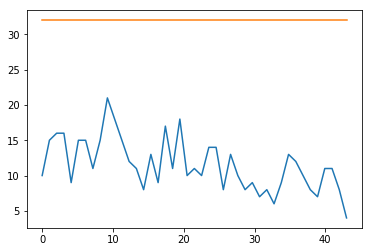

In [19]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0,len(cycle_list),len(cycle_list))
y = [32 for _ in range(len(cycle_list))]
plt.plot(x,cycle_list)
plt.plot(x,y)
plt.show()

In [13]:
row_n = 32
col_n = 1
myArray = SystolicArray(row_n, col_n)

#src = [0,1,2,1,2,0,2,0,1]
#dst = [0,1,2,0,1,2,0,1,2]

#src = [0,0,0,0,1,1,2,2,2]
#dst = [0,1,3,5,2,4,0,3,5]

#src = [0,1,1,2,0,0,0,2,2]
#dst = [0,2,4,0,1,3,5,3,5]

#src = [0,1,1,2,0,1,0,2,2]
#dst = [0,2,4,0,1,3,5,4,5]

#src = [0,0,1,2]
#dst = [0,1,2,0]

#myArray.fill_edges(2708, src, dst)
#myArray.edge_load_balance(row_n, src, dst)
myArray.edge_dual_ring_boardcase(row_n, src, dst)

#idx = [0,1,2]
myArray.fill_idx(idx)
myArray.fill_result_banks(2708)       
edge_count = 0
res = myArray.run(2708)
#assert (res == np.matmul(activations, weights)).all()
#print('Systolic array matches numpy matmul')

-----Cycle----0----------
compute cell(0,0) src 0, dst 544
compute cell(0,1) src 9, dst 481
compute cell(0,2) src 0, dst 258
compute cell(0,3) src 22, dst 163
compute cell(0,4) src 10, dst 420
compute cell(0,5) src 3, dst 197
compute cell(0,6) src 21, dst 294
compute cell(0,7) src 10, dst 519
compute cell(0,8) src 0, dst 8
compute cell(0,9) src 14, dst 393
compute cell(0,10) src 4, dst 170
compute cell(0,11) src 18, dst 427
compute cell(0,12) src 14, dst 268
compute cell(0,13) src 24, dst 269
compute cell(0,14) src 0, dst 14
compute cell(0,15) src 3, dst 463
compute cell(0,16) src 11, dst 624
compute cell(0,17) src 22, dst 2257
compute cell(0,18) src 13, dst 1234
compute cell(0,19) src 0, dst 435
compute cell(0,20) src 5, dst 2164
compute cell(0,21) src 2, dst 565
compute cell(0,22) src 16, dst 566
compute cell(0,23) src 2, dst 471
compute cell(0,24) src 1, dst 344
compute cell(0,25) src 3, dst 601
compute cell(0,26) src 2, dst 410
compute cell(0,27) src 6, dst 251
compute cell(0,28) s

In [14]:
edge_count

127

In [52]:
src = [0,1,1,2,0,1,0,2,2,0,0]
dst = [0,2,4,0,1,3,5,4,5,3,4]

In [53]:
edge_bank   = [Queue() for _ in range(3)]

In [54]:
Edge_bucket   = [Queue() for _ in range(3)]

In [55]:
Edge_list  = [list() for _ in range(3)]

In [56]:
for idx in sorted(zip(src, dst), key=itemgetter(1)):
    src, dst = idx
    Edge_list[dst%3].append(idx)

In [61]:
for idx in Edge_list:
    for val in sorted(idx):
        edge_bank[]
        

[(0, 0), (2, 0), (1, 3), (0, 3)]
[(0, 0), (0, 3), (1, 3), (2, 0)]
[(0, 1), (1, 4), (2, 4), (0, 4)]
[(0, 1), (0, 4), (1, 4), (2, 4)]
[(1, 2), (0, 5), (2, 5)]
[(0, 5), (1, 2), (2, 5)]


In [62]:
def edge_dual_ring_boardcase(row_n, src, dst):
    Edge_list  = [list() for _ in range(row_n)]
    for idx in sorted(zip(src, dst), key=itemgetter(1)):
        src, dst = idx
        Edge_list[dst%3].append(idx)
    for idx_, val in Edge_list:
        for val_ in sorted(val):
            edge_bank[idx_].put(val_)

In [30]:
    def edge_bucket_empty(e_b):
        for idx in e_b:
            for id_ in idx:
                if id_.empty() is False:
                    return True
        return False

    def edge_load_balance(row_n, src, dst):
        Edge_bucket   = [[Queue() for _ in range(row_n)] for _ in range(row_n)]
        for idx in sorted(zip(src, dst)):
            src, dst = idx
            Edge_bucket[src%row_n][dst%row_n].put(idx)
        while(edge_bucket_empty(Edge_bucket)):
            for i in range(row_n):
                num = [j for j in range(i,row_n)]
                for n in range(i):
                    num.append(n)
                for id_, val in enumerate(num):
                    print("--({:d}, {:d})". format(val, id_))
                    if Edge_bucket[val][id_].empty() is False:
                        print(Edge_bucket[val][id_].get())
                        #edge_bank[id_].put(Edge_bucket[val][id_].get())

In [31]:
edge_load_balance(3, src, dst)

--(0, 0)
(0, 0)
--(1, 1)
(1, 4)
--(2, 2)
(2, 5)
--(1, 0)
(1, 3)
--(2, 1)
(2, 4)
--(0, 2)
(0, 5)
--(2, 0)
(2, 0)
--(0, 1)
(0, 1)
--(1, 2)
(1, 2)
